In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable warnings, info and errors 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7  #占用85%显存
# session = tf.compat.v1.Session(config=config)

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
import imageio

import re
from IPython import display

In [2]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Preprocess Text


In [4]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [5]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [6]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
# df = pd.read_pickle(data_path+ '/testData.pkl' )
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [7]:
df.head(5)


,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [8]:
def ids2textlist(index_lists):
    result = []
    for index_list in index_lists:
        text = ''
        for idx in index_list:
            if idx == word2Id_dict['<PAD>']:
                break
            elif idx == word2Id_dict['<RARE>']:
                pass
            else:
                text += id2word_dict[idx] + ' '
        if text != '':
            result.append(text.strip())
    return result

def ids2text(index):
    text = ''
    for idx in index:
        if idx == word2Id_dict['<PAD>']:
            break
        elif idx == word2Id_dict['<RARE>']:
            pass
        else:
            text += id2word_dict[idx] + ' '
    return text

In [9]:
df['texts'] = df['Captions'].apply(lambda x: ids2textlist(x))
# df['texts'] = df['Captions'].apply(lambda x: ids2text(x))

In [10]:
df.iloc[0]['texts']

['the petals of the flower are pink in color and have a yellow center',
 'this flower is pink and white in color with petals that are multi colored',
 'the purple petals have shades of white with white anther and filament',
 'this flower has large pink petals and a white stigma in the center',
 'this flower has petals that are pink and has a yellow stamen',
 'a flower with short and wide petals that is light purple',
 'this flower has small pink petals with a yellow center',
 'this flower has large rounded pink petals with curved edges and purple veins',
 'this flower has purple petals as well as a white stamen']

## GET captions embedding 

In [11]:
# from transformers import BertTokenizer, TFBertModel
# from transformers import AutoTokenizer, TFAutoModel
# import transformers
# import logging
# transformers.logging.get_verbosity = lambda: logging.NOTSET
# bert_tokenizer = AutoTokenizer.from_pretrained('roberta-large')
# bert_model = TFAutoModel.from_pretrained('roberta-large')

In [12]:
def get_caption_embedding(string_list):
    inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
    bert_outputs = bert_model(inputs)
    caption_embedding = bert_outputs.pooler_output
    caption_embedding = caption_embedding.numpy()
    return caption_embedding.tolist()


In [13]:
# from datetime import datetime
# print("{}, start infering.".format(datetime.now()))
# df['embeddings'] = df['texts'].apply(lambda x : get_caption_embedding(x))
# print("{}, end infering.".format(datetime.now()))
# # df.to_pickle("./dataset/text2img_cls_embedding.pkl")
# df.to_pickle("./dataset/testData_cls_embedding.pkl")


In [14]:
# def make_list_of_list(caption):
#     return [caption]

In [15]:
# df = pd.read_pickle("./dataset/testData_cls_embedding.pkl")
# df['Captions'] = df['Captions'].apply(lambda x: make_list_of_list(x))
# df.head()

In [16]:
# df.to_pickle("./dataset/testData_cls_embedding.pkl")


## start to build dataset

In [17]:
df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")

In [18]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [19]:
def load_img(img_path):
    raw_img = tf.io.read_file(img_path)
    return raw_img

In [20]:
def serialize_example(img):
    feature = {
        'img': _bytes_feature(img)
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [21]:
def tf_serialize_example(img):
    tf_string = tf.py_function(
        serialize_example,
        [img],  
        tf.string)      
    return tf.reshape(tf_string, ()) 

In [22]:
image_paths = df['ImagePath'].values
image_paths = np.asarray(image_paths)

In [23]:
# write_record_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
# write_record_dataset = write_record_dataset.map(load_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)
# write_record_dataset = write_record_dataset.map(tf_serialize_example,num_parallel_calls=tf.data.experimental.AUTOTUNE)
# filename = f'train.tfrecord'
# writer = tf.data.experimental.TFRecordWriter(filename)
# writer.write(write_record_dataset)

In [24]:
raw_dataset_train = tf.data.TFRecordDataset(['train.tfrecord'])
raw_dataset_train

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [25]:
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img']

In [26]:
raw_dataset_train = raw_dataset_train.map(_parse_function)
raw_dataset_train

<MapDataset shapes: (), types: tf.string>

In [27]:
BATCH_SIZE = 100
BUFFER_SIZE = 2000
DATASET_SIZE = 211485

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

hparas = {
    'EMBED_DIM': 1024,                         # word embedding dimension
    'Z_DIM': 256,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': DATASET_SIZE // BATCH_SIZE,          # size of training data
    'rs_Train': float(BATCH_SIZE) / float(DATASET_SIZE), 
    'CHECKPOINTS_DIR': './checkpoints/train_bz100',  # checkpoint path
    'PRINT_FREQ': 1,                       # printing frequency of loss
    'BZ':(BATCH_SIZE,256),
    'TEST_Z':(SAMPLE_NUM,256),
    'TEST_BATCH_SIZE':91
}


In [28]:
def processing(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img = tf.cast(img,tf.float32)
    img = img / 255.
    return img

In [29]:
raw_dataset_train = raw_dataset_train.map(processing)

In [30]:
imgs = []
for img in raw_dataset_train:
    imgs.append(img.numpy())

In [31]:
def training_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. - 1.
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

def flip_right_left_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. -1.
    img = tf.image.flip_left_right(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding


def adjust_brightness_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.random_brightness(img, 0.2, 2)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. -1.
    img = tf.image.flip_up_down(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

In [32]:
df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")

embeddings = df['embeddings'].values

embedding = []

img_for_dataset = []

for i in range(len(embeddings)):
    for emb in embeddings[i]:
        embedding.append(emb)
        img_for_dataset.append(imgs[i])
embedding = np.asarray(embedding)
img_for_dataset = np.asarray(img_for_dataset)

assert embedding.shape[0] == img_for_dataset.shape[0]

In [33]:
dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
dataset = dataset.map(training_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
flip_right_left_dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
flip_right_left_dataset = flip_right_left_dataset.map(flip_right_left_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
adjust_brightness_dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
adjust_brightness_dataset = adjust_brightness_dataset.map(adjust_brightness_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.concatenate(flip_right_left_dataset)
dataset = dataset.concatenate(adjust_brightness_dataset)

In [34]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset

<PrefetchDataset shapes: ((100, 64, 64, 3), (100, 1024)), types: (tf.float32, tf.float32)>

In [35]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.to_4_4_1024 = tf.keras.layers.Dense(4*4*1024)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        self.dc1 = tf.keras.layers.Conv2DTranspose(
            filters = 512,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc2 = tf.keras.layers.Conv2DTranspose(
            filters = 256,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc3 = tf.keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc4 = tf.keras.layers.Conv2DTranspose(
            filters = 3,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        
        
    def call(self, noise_z, text, training):
        # compress the embedding
        text = self.compress(text)
        text = self.lr1(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        
        # To 4*4*1024
        text_concat = self.to_4_4_1024(text_concat)
        text_concat = tf.reshape(text_concat, [-1, 4, 4, 1024])
        text_concat = self.bn1(text_concat,training=training)
        text_concat = self.lr2(text_concat)
        
        # To 8*8*512
        text_concat = self.dc1(text_concat)
        text_concat = self.bn2(text_concat,training=training)
        text_concat = self.lr3(text_concat)
        
        # To 16*16*256
        text_concat = self.dc2(text_concat)
        text_concat = self.bn3(text_concat,training=training)
        text_concat = self.lr4(text_concat)
        
        # To 32*32*128
        text_concat = self.dc3(text_concat)
        text_concat = self.bn4(text_concat,training=training)
        text_concat = self.lr5(text_concat)
        
        # To 64*64*3
        text_concat = self.dc4(text_concat)
        
        output = tf.nn.tanh(text_concat)
        
        return output

In [36]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
        
        self.relu = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = (64,64,3))
        
        self.conv2 = tf.keras.layers.Conv2D(
            filters = 256,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv3 = tf.keras.layers.Conv2D(
            filters = 512,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv4 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv5 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 1,
            strides = (1, 1),
            padding = "SAME")
    
    def call(self, img, text, training):
        # Conpress embedding
        text = self.compress(text)
        text = self.relu(text)
        # To 32*32*128
        img = self.conv1(img)
        #img = self.bn1(img,training=training)
        img = self.lr1(img)
        # To 16*16*256
        img = self.conv2(img)
        #img = self.bn2(img,training=training)
        img = self.lr2(img)
        # To 8*8*512
        img = self.conv3(img)
        #img = self.bn3(img,training=training)
        img = self.lr3(img)
        # To 4*4*1024
        img = self.conv4(img)
        #img = self.bn4(img,training=training)
        img = self.lr4(img)
        
        # concatenate image with paired text
        text = tf.expand_dims(text,axis=1)
        text = tf.expand_dims(text,axis=1)
        text = tf.tile(text,multiples=[1,4,4,1])
        img_text = tf.concat([img, text], axis=-1)
        
        img_text = self.conv5(img_text)
        #img_text = self.bn5(img_text,training=training)
        img_text = self.relu2(img_text)
        
        img_text = tf.reshape(img_text, [-1, 4*4*1024])
        
        
        score = self.d(img_text)
        return score

In [ ]:
# ''' modified from lab14-2 '''

# class Generator(tf.keras.Model):
#     """
#     Generate fake image based on given text(hidden representation) and noise z
#     input: text_embedding(text_embed) and random noise(z)
#     output: fake image with size 64*64*3
#     """
    
    
#     def __init__(self, hparas):
#         super(Generator, self).__init__()
#         self.hparas = hparas
        
#         # local parameters
#         self.target_h, self.target_w, self.target_d = self.hparas['IMAGE_SIZE']
#         self.number_invConv2d = 3
#         self.depth_len = 512
        
#         # 1. compress text_embed and concate noise and text_embed
#         self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
#         self.lr1_1 = tf.keras.layers.ReLU()
        
#         # 2. forward concatenated text_embed to NN
#         # ref: https://ithelp.ithome.com.tw/articles/10227196
#         ## format: dense -> [batchnormalization -> (leaky) relu -> conv2dtranspose] -> [] -> ...
        
#         self.d2_1 = tf.keras.layers.Dense(units = \
#             int(self.target_h//(2**self.number_invConv2d) * self.target_w//(2**self.number_invConv2d) * self.depth_len))
#         self.bn2_1 = tf.keras.layers.BatchNormalization()
#         self.lr2_1 = tf.keras.layers.ReLU()
#         self.invConv2d2_1 = tf.keras.layers.Conv2DTranspose(
#             filters = 256,
#             kernel_size = 5,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.bn2_2 = tf.keras.layers.BatchNormalization()
#         self.lr2_2 = tf.keras.layers.ReLU()
#         self.invConv2d2_2 = tf.keras.layers.Conv2DTranspose(
#             filters = 128,
#             kernel_size = 5,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.bn2_3 = tf.keras.layers.BatchNormalization()
#         self.lr2_3 = tf.keras.layers.ReLU()
#         self.invConv2d2_3 = tf.keras.layers.Conv2DTranspose(
#             filters = 3, ## should be 3, as the output should be an image with shpae 64x64x3
#             kernel_size = 5,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.activation = tf.nn.tanh
    
    
#     def call(self, noise_z, text_embed, training):
#         # 1. compress the embedding and concatenate text_embed and random noise 
#         text_embed = self.compress(text_embed)
#         text_embed = self.lr1_1(text_embed)
        
#         text_concat = tf.concat([noise_z, text_embed], axis=1)
        
        
#         text_concat = self.d2_1(text_concat)
#         text_concat = tf.reshape(text_concat, [-1, self.target_h//(2**self.number_invConv2d), \
#                                                self.target_w//(2**self.number_invConv2d), self.depth_len])
                                 
#         # To 16*16*256
#         text_concat = self.bn2_1(text_concat,training=training)
#         text_concat = self.lr2_1(text_concat)
#         text_concat = self.invConv2d2_1(text_concat)
                                 
#         # To 32*32*128
#         text_concat = self.bn2_2(text_concat,training=training)
#         text_concat = self.lr2_2(text_concat)
#         text_concat = self.invConv2d2_2(text_concat)
        
#         # To 64*64*3
#         #text_concat = self.bn2_3(text_concat,training=training)
#         text_concat = self.lr2_3(text_concat)
#         text_concat = self.invConv2d2_3(text_concat)
        
#         # activation usnig tanh
#         output = self.activation(text_concat)
        
#         return output
        
        
        
# class Discriminator(tf.keras.Model):
#     """
#     Differentiate the real and fake image
#     input: image and corresponding text_embed
#     output: labels, the real image should be 1, while the fake should be 0
#     """
    
#     '''
#     1. Compress(Dense) text_embed and fake image into same length('DENSE_DIM') 
#     2. Concatenate them
#     3. Dense to one value, which is the final score
#     '''
#     def __init__(self, hparas):
#         super(Discriminator, self).__init__()
#         self.hparas = hparas
        
#         # 1-1. compress text_embed
#         self.compress_text_embed = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
#         self.lr_text_embed = tf.keras.layers.LeakyReLU()
        
#         # 1-2. compress fake image
#         ## format: [convolution2d(stride=2) -> batchnormalization -> "leaky" relu!] -> []* 
#         ##          -> flatten -> dense
        
#         self.conv2d1 = tf.keras.layers.Conv2D(
#             filters = 128,
#             kernel_size = 5,
#             strides = (2, 2),
#             padding = "SAME",
#             input_shape = (self.hparas['IMAGE_SIZE'])
#         )
#         self.bn1 = tf.keras.layers.BatchNormalization()
#         self.lr1 = tf.keras.layers.LeakyReLU()
        
#         self.conv2d2 = tf.keras.layers.Conv2D(
#             filters = 256,
#             kernel_size = 5,
#             strides = (2, 2),
#             padding = "SAME"
#         )
#         self.bn2 = tf.keras.layers.BatchNormalization()
#         self.lr2 = tf.keras.layers.LeakyReLU()
        
#         self.conv2d3 = tf.keras.layers.Conv2D(
#             filters = 512,
#             kernel_size = 5,
#             strides = (2, 2),
#             padding = "SAME"
#         )
#         self.bn3 = tf.keras.layers.BatchNormalization()
#         self.lr3 = tf.keras.layers.LeakyReLU()
        
#         # 2. compress img into the dim. that same with text_embed, and concatenate them
#         self.flatten = tf.keras.layers.Flatten()
#         self.d = tf.keras.layers.Dense(units = self.hparas['DENSE_DIM'])
        
#         # 3. forward the concatenated tensor
#         self.bn4 = tf.keras.layers.BatchNormalization()
#         self.lr4 = tf.keras.layers.LeakyReLU()
#         self.score = tf.keras.layers.Dense(units = 1)
        
#     def call(self, img, text_embed, training):
#         # 1-1. compress text_embed
#         text_embed = self.compress_text_embed(text_embed)
#         text_embed = self.lr_text_embed(text_embed)
        
#         # 1-2. compress fake image
#         ## format: [convolution2d(stride=2) -> batchnormalization -> "leaky" relu!] -> []* 
#         ##          -> flatten -> dense
        
#         img = self.conv2d1(img)
#         img = self.bn1(img)
#         img = self.lr1(img)
        
#         img = self.conv2d2(img)
#         img = self.bn2(img)
#         img = self.lr2(img)
        
#         img = self.conv2d3(img)
#         img = self.bn3(img)
#         img = self.lr3(img)
        
#         # 2. compress img into the dim. that same with text_embed, and concatenate them
#         img = self.flatten(img)
#         img = self.d(img)
        
#         img_text_embed = tf.concat([text_embed, img], axis = 1)
        
#         # 3. forward the concatenated tensor
#         img_text_embed = self.bn4(img_text_embed)
#         img_text_embed = self.lr4(img_text_embed)
#         final_score = self.score(img_text_embed)
        
#         return final_score

In [ ]:
# ''' similar structure '''
# '''  ref: https://github.com/aditya30394/Reverse-Image-Captioning/blob/a6e427624a64f28d08e5629f48850ff001e48d02/nets/generator.py#L7 '''
# class Generator(tf.keras.Model):
#     """
#     Generate fake image based on given text(hidden representation) and noise z
#     input: text_embedding(text_embed) and random noise(z)
#     output: fake image with size 64*64*3
#     """
    
    
#     def __init__(self, hparas):
#         super(Generator, self).__init__()
#         self.hparas = hparas
        
#         # local parameters
#         self.target_h, self.target_w, self.target_d = self.hparas['IMAGE_SIZE']
#         self.number_invConv2d = 5
#         self.depth_len = 512
        
#         # 1. compress text_embed and concate noise and text_embed
#         self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
#         self.lr1_1 = tf.keras.layers.ReLU()
        
#         # 2. forward concatenated text_embed to NN
#         # ref: https://ithelp.ithome.com.tw/articles/10227196
#         ## format: dense -> [batchnormalization -> (leaky) relu -> conv2dtranspose] -> [] -> ...
        
#         self.d2_1 = tf.keras.layers.Dense(units = \
#             int(self.target_h//(2**self.number_invConv2d) * self.target_w//(2**self.number_invConv2d) * self.depth_len))
#         self.bn2_1 = tf.keras.layers.BatchNormalization()
#         self.lr2_1 = tf.keras.layers.ReLU()
#         self.invConv2d2_1 = tf.keras.layers.Conv2DTranspose(
#             filters = 512,
#             kernel_size = 4,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.bn2_2 = tf.keras.layers.BatchNormalization()
#         self.lr2_2 = tf.keras.layers.ReLU()
#         self.invConv2d2_2 = tf.keras.layers.Conv2DTranspose(
#             filters = 256,
#             kernel_size = 4,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.bn2_3 = tf.keras.layers.BatchNormalization()
#         self.lr2_3 = tf.keras.layers.ReLU()
#         self.invConv2d2_3 = tf.keras.layers.Conv2DTranspose(
#             filters = 128, ## should be 3, as the output should be an image with shpae 64x64x3
#             kernel_size = 4,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.bn2_4 = tf.keras.layers.BatchNormalization()
#         self.lr2_4 = tf.keras.layers.ReLU()
#         self.invConv2d2_4 = tf.keras.layers.Conv2DTranspose(
#             filters = 64, ## should be 3, as the output should be an image with shpae 64x64x3
#             kernel_size = 4,
#             strides = 2,
#             padding = "SAME",
#         )
        
        
#         # last layer no leaky relu and bn
#         self.invConv2d2_5 = tf.keras.layers.Conv2DTranspose(
#             filters = 3, ## should be 3, as the output should be an image with shpae 64x64x3
#             kernel_size = 4,
#             strides = 2,
#             padding = "SAME",
#         )
        
#         self.activation = tf.nn.tanh
    
    
#     def call(self, noise_z, text_embed, training):
#         # 1. compress the embedding and concatenate text_embed and random noise 
#         text_embed = self.compress(text_embed)
#         text_embed = self.lr1_1(text_embed)
        
#         text_concat = tf.concat([noise_z, text_embed], axis=1)
        
        
#         text_concat = self.d2_1(text_concat)
#         text_concat = tf.reshape(text_concat, [-1, self.target_h//(2**self.number_invConv2d), \
#                                                self.target_w//(2**self.number_invConv2d), self.depth_len])
                                 
#         # To 16*16*256
#         text_concat = self.bn2_1(text_concat,training=training)
#         text_concat = self.lr2_1(text_concat)
#         text_concat = self.invConv2d2_1(text_concat)
                                 
#         # To 32*32*128
#         text_concat = self.bn2_2(text_concat,training=training)
#         text_concat = self.lr2_2(text_concat)
#         text_concat = self.invConv2d2_2(text_concat)
        
#         # To 64*64*3
#         text_concat = self.bn2_3(text_concat,training=training)
#         text_concat = self.lr2_3(text_concat)
#         text_concat = self.invConv2d2_3(text_concat)
        
#         text_concat = self.bn2_4(text_concat,training=training)
#         text_concat = self.lr2_4(text_concat)
#         text_concat = self.invConv2d2_4(text_concat)
        
#         text_concat = self.invConv2d2_5(text_concat)
        
#         # activation usnig tanh
#         output = self.activation(text_concat)
        
#         return output
        
        
        
# class Discriminator(tf.keras.Model):
#     """
#     Differentiate the real and fake image
#     input: image and corresponding text_embed
#     output: labels, the real image should be 1, while the fake should be 0
#     """
    
#     '''
#     1. Compress(Dense) text_embed and fake image into same length('DENSE_DIM') 
#     2. Concatenate them
#     3. Dense to one value, which is the final score
#     '''
#     def __init__(self, hparas):
#         super(Discriminator, self).__init__()
#         self.hparas = hparas
        
#         # 1-1. compress text_embed
#         self.compress_text_embed = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
#         self.lr_text_embed = tf.keras.layers.LeakyReLU()
        
#         # 1-2. compress fake image
#         ## format: [convolution2d(stride=2) -> batchnormalization -> "leaky" relu!] -> []* 
#         ##          -> flatten -> dense
        
#         self.conv2d1 = tf.keras.layers.Conv2D(
#             filters = 128,
#             kernel_size = 4,
#             strides = (2, 2),
#             padding = "SAME",
#             input_shape = (self.hparas['IMAGE_SIZE'])
#         )
#         self.bn1 = tf.keras.layers.BatchNormalization()
#         self.lr1 = tf.keras.layers.LeakyReLU(0.2)
        
#         self.conv2d2 = tf.keras.layers.Conv2D(
#             filters = 256,
#             kernel_size = 4,
#             strides = (2, 2),
#             padding = "SAME"
#         )
#         self.bn2 = tf.keras.layers.BatchNormalization()
#         self.lr2 = tf.keras.layers.LeakyReLU(0.2)
        
#         self.conv2d3 = tf.keras.layers.Conv2D(
#             filters = 512,
#             kernel_size = 4,
#             strides = (2, 2),
#             padding = "SAME"
#         )
#         self.bn3 = tf.keras.layers.BatchNormalization()
#         self.lr3 = tf.keras.layers.LeakyReLU(0.2)
        
#         self.conv2d4 = tf.keras.layers.Conv2D(
#             filters = 1024,
#             kernel_size = 4,
#             strides = (2, 2),
#             padding = "SAME"
#         )
#         self.bn4 = tf.keras.layers.BatchNormalization()
#         self.lr4 = tf.keras.layers.LeakyReLU(0.2)
        
        
#         # 2. compress img into the dim. that same with text_embed, and concatenate them
#         self.flatten = tf.keras.layers.Flatten()
# #        self.d = tf.keras.layers.Dense(units = self.hparas['DENSE_DIM'])
        
#         # 3. forward the concatenated tensor
#         self.conv2d3_1 = tf.keras.layers.Conv2D(
#             filters = 1024,
#             kernel_size = 4,
#             strides = (1, 1),
#             padding = "SAME"
#         )
#         self.bn3_1 = tf.keras.layers.BatchNormalization()
#         self.lr3_1 = tf.keras.layers.LeakyReLU()
#         self.d = tf.keras.layers.Dense(units = 1)
#         self.score = tf.math.sigmoid
        
#     def call(self, img, text_embed, training):
#         # 1-1. compress text_embed
#         text_embed = self.compress_text_embed(text_embed)
#         text_embed = self.lr_text_embed(text_embed)
        
#         # 1-2. compress fake image
#         ## format: [convolution2d(stride=2) -> batchnormalization -> "leaky" relu!] -> []* 
#         ##          -> flatten -> dense
        
#         img = self.conv2d1(img)
#         img = self.bn1(img)
#         img = self.lr1(img)
        
#         img = self.conv2d2(img)
#         img = self.bn2(img)
#         img = self.lr2(img)
        
#         img = self.conv2d3(img)
#         img = self.bn3(img)
#         img = self.lr3(img)
        
#         img = self.conv2d4(img)
#         img = self.bn4(img)
#         img = self.lr4(img)
        
# #         img = self.conv2d5(img)
# #         img = self.bn5(img)
# #         img = self.lr5(img)
        
#         # 2. compress img into the dim. that same with text_embed, and concatenate them
        
#         text_embed_reduce = tf.expand_dims(text_embed,axis=1)
#         text_embed_reduce = tf.expand_dims(text_embed_reduce,axis=1)
#         text_embed_reduce = tf.tile(text_embed_reduce,multiples=[1,4,4,1])
# #         print(text_embed_reduce.shape)
# #         print(img.shape)
#         concat_out = tf.concat([img, text_embed_reduce], axis = -1)
        
        
#         # 3. forward the concatenated tensor
        
#         concat_out = self.conv2d3_1(concat_out)
#         concat_out = self.bn3_1(concat_out)
#         concat_out = self.lr3_1(concat_out)
        
#         concat_out = self.flatten(concat_out)
# #        concat_out = self.d(concat_out)
# #        concat_out = tf.reshape(concat_out, [-1, 4*4*1024])
#         final_score = self.d(concat_out)
        
#         return final_score

In [37]:
len(dataset)

2114

In [38]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [40]:
checkpoint_path = hparas['CHECKPOINTS_DIR']
ckpt = tf.train.Checkpoint(generator = generator,
                           discriminator = discriminator,
                           generator_optimizer = generator_optimizer,
                           discriminator_optimizer = discriminator_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [41]:
@tf.function
def DC_D_Train(c1,embed,noise_decay):
    z = tf.random.normal(hparas['BZ']) 

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x_bar = generator(z, embed, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise_decay * tf.random.normal(x_bar.shape)
            x = x + noise_decay * tf.random.normal(x.shape)
            x_hat = x_hat + noise_decay * tf.random.normal(x_hat.shape)

            z0 = discriminator(x_bar, embed, training = True)
            z1 = discriminator(x, embed, training = True)
            z2 = discriminator(x_hat, embed, training = True)

            gradient_penalty = tp_2.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tp.gradient(ld, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

    return lg, ld

@tf.function
def DC_G_Train(c1,embed,noise_decay):
    
    z = tf.random.normal(hparas['BZ'])

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x_bar = generator(z, embed, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise_decay * tf.random.normal(x_bar.shape)
            x = x + noise_decay * tf.random.normal(x.shape)
            x_hat = x_hat + noise_decay * tf.random.normal(x_hat.shape)

            z0 = discriminator(x_bar, embed, training = True)
            z1 = discriminator(x, embed, training = True)
            z2 = discriminator(x_hat, embed, training = True)
            gradient_penalty = tp_2.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tp.gradient(lg, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

    return lg, ld

In [42]:
@tf.function
def test_step(noise, embed):
    fake_image = generator(noise, embed, training = False)
    return fake_image

In [43]:
embeddings = df['embeddings'].values
ids = df['Captions'].values

test_embed = []

for i in range(8):
    if len(embeddings[i]) >= 8:
        for j in range(8):
            test_embed.append(embeddings[i][j])
            
test_noise = tf.random.normal(hparas['TEST_Z'])
test_embed = tf.Variable(test_embed)

In [44]:
Train = (
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_G_Train
)

Critic = len(Train)

In [45]:
# ckpt.restore('./checkpoints/train/ckpt-10')

In [ ]:
wlg = [None] * hparas['N_EPOCH'] #record loss of g for each epoch
wld = [None] * hparas['N_EPOCH']  #record loss of d for each epoch
wsp = [None] * hparas['N_EPOCH']  #record sample images for each epoch

rsTrain = hparas['rs_Train']
ctr = 0
for ep in range(hparas['N_EPOCH']):
    print("Epoch: " + str(ep+1), end='\r')
    print('')
    lgt = 0.0
    ldt = 0.0
    if ep < 200:
        noise_decay = 1.0 / float(ep+1)
    else:
        noise_decay = 0.0
        
    for idx, (real_img,embed) in enumerate(dataset):
        print(str(idx+1) + '/' + str(hparas['N_SAMPLE']), end='\r')
        lg, ld = Train[ctr](real_img, embed, noise_decay)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == Critic : ctr = 0
    print('')

    with open('./wlg_v2.txt','a') as f:
        f.write(str(lgt * rsTrain) + '\n')
    f.close()
    with open('./wld_v2.txt','a') as f:
        f.write(str(ldt * rsTrain) + '\n')
    f.close()
    
    out = test_step(test_noise, test_embed)
    img = utPuzzle(
        ((out+1) / 2. * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs_v2/w_%04d.png" % ep
    )
#     wsp[ep] = img
    if (ep+1) % 10 == 0: 
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % (ep+1))
        plt.show()
    if (ep+1) % 10 == 0: 
        ckpt_manager.save()

Epoch: 1
2114/2114
Epoch: 2


## Inference

In [58]:
test_df = pd.read_pickle("./dataset/testData_cls_embedding.pkl")
embeddings = test_df['embeddings'].values
embedding = []
for i in range(len(embeddings)):
    for emb in embeddings[i]:
        embedding.append(emb)
embedding = np.asarray(embedding)
print(len(embedding))
index = test_df['ID'].values
index = np.asarray(index)
print(len(index))

819
819


In [59]:
TEST_BATCH_SIZE = 39

In [60]:
def testing_data_generator(embedding, index):
    embedding = tf.cast(embedding, tf.float32)
    return embedding, index

In [61]:
test_dataset = tf.data.Dataset.from_tensor_slices((embedding, index))
test_dataset = test_dataset.map(testing_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset

<PrefetchDataset shapes: ((39, 1024), (39,)), types: (tf.float32, tf.int64)>

In [62]:
for i, (embed, idx) in enumerate(test_dataset):
    z = tf.random.normal((TEST_BATCH_SIZE,256))
    fake_image = test_step(z, embed)
    for i in range(TEST_BATCH_SIZE):
        plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)

this white and purple flower has fragile petals and soft stamens 
this flower has four large wide pink petals with white centers and vein like markings 
a flower with broad white and pink ribbed petals and yellow stamen 
one prominet pistil with alarger stigam and many stamens with anthers 
leaves are green in color petals are light pink in color 


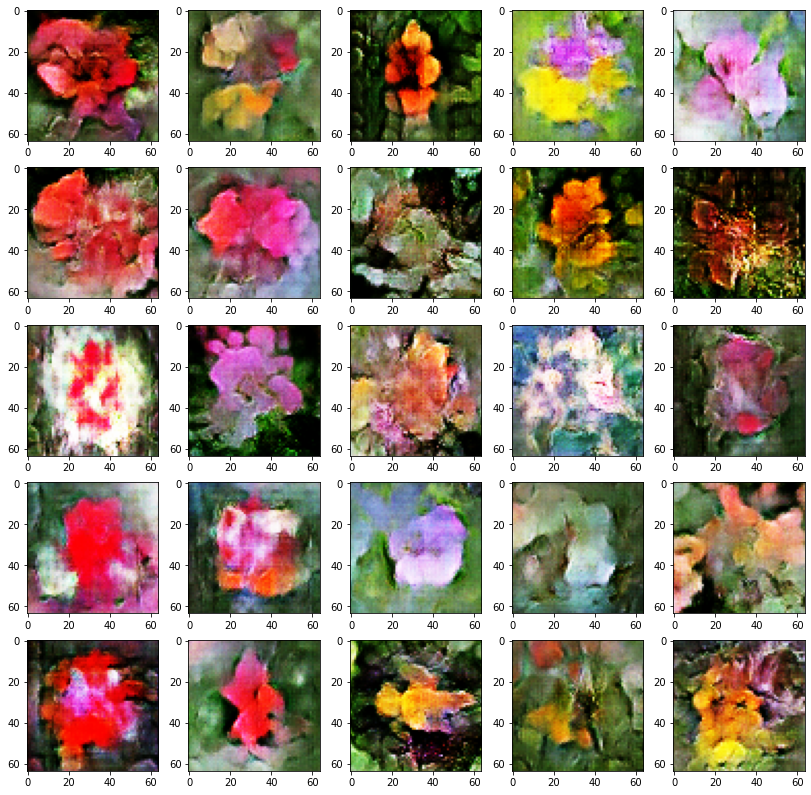

(0.0, 1.0, 0.0, 1.0)

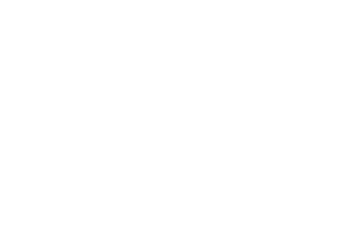

In [77]:
## Build Image For Demo

_, axs = plt.subplots(5, 5, figsize=(14, 14))


imgs = []

# fig = plt.figure(figsize=(14, 14))
# count = 0
for i in range(5):
    print(df.iloc[i]['texts'])
    demo_embed = df.iloc[i]['embeddings']
    demo_embed = np.array(demo_embed)
    demo_embed = np.repeat(demo_embed, 5 , axis=0)
    demo_embed = tf.cast(demo_embed, tf.float32)
    z = tf.random.normal((5,256))
    fake_image = test_step(z, demo_embed)
    for k in range(5):
        img_to_print  = fake_image[k].numpy()*0.5 + 0.5
#         plt.imsave('./inference/report/report_{}_{}.jpg'.format(i, k), img_to_print)
        imgs.append(img_to_print)
#         plt.subplot(7, 7, count+1)
#         plt.imshow(img_to_print)
#         plt.axis('off')

axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()
plt.axis('off')